In [121]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img, norm):
    """
    :param img: (PyTorch Tensor)
    """
    if norm:
        # unnormalize
        img = img / 2 + 0.5    
        
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_image(img):
    """
    convert a tensor to images suitable for plotting
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    return np.transpose(npimg, (1, 2, 0))

def plot_loss_acc(train_loss, val_loss, train_acc, val_acc):
    x = np.arange(1, len(train_loss) + 1)

    fig,axs = plt.subplots(1, 2, figsize=(16,6))
    axs[0].plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    axs[0].plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    axs[0].set_title("Evolution of the training, validation and test loss")

    axs[1].plot(x, train_acc, color=colors[0], label="Training accuracy", linewidth=2)
    axs[1].plot(x, val_acc, color=colors[1], label="Validation accuracy", linewidth=2)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    axs[1].set_title("Evolution of the training, validation and test accuracy")
    plt.show()
    

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

def plot_pvals(pvals, labels):
    idx_in = np.where(labels==0)[0]
    idx_out = np.where(labels==1)[0]

    pvals_in = np.array(pvals)[idx_in]
    pvals_out = np.array(pvals)[idx_out]

    plt.figure(figsize=(8,6))
    plt.hist(pvals_in, bins=100, alpha=0.5, label="inliers")
    plt.hist(pvals_out, bins=100, alpha=0.5, label="outliers")
    plt.legend()
    plt.show

    print('Average p-value for inliers is {:3f}, average p-value for outliers is {:3f}.'\
          .format(np.mean(pvals_in), np.mean(pvals_out)))
    

def evaluate_bh(pvals, labels, alpha):
    idx_in = np.where(labels==0)[0]
    idx_out = np.where(labels==1)[0]
    
    # Apply BH
    purity_test = len(idx_in)/len(pvals)
    reject, _, _, _ = multipletests(pvals, alpha=alpha/(1-purity_test), method='fdr_bh')

    # Evaluate FDP and Power
    rejections = np.sum(reject)
    if rejections > 0:
        fdp = np.sum(reject[idx_in])/reject.shape[0] 
        power = np.sum(reject[idx_out])/len(idx_out)
    else:
        fdp = 0
        power = 0
    return fdp, power

def evaluate_predictions(S, y):
    coverage = np.mean([y[i] in S[i] for i in range(len(y))])
    length = np.mean([len(S[i]) for i in range(len(y))])
    idx_cover = np.where([y[i] in S[i] for i in range(len(y))])[0]
    length_cover = np.mean([len(S[i]) for i in idx_cover])
    return coverage, length, length_cover

def evaluate_marginal(S, y):
    coverage, length, length_cover = evaluate_predictions(S, y)
    print('Marginal coverage:       {:2.3%}'.format(coverage))
    print('Average size:            {:2.3f}'.format(length))
    print('Average size | coverage: {:2.3f}'.format(length_cover))

def evaluate_conditional(S, y):
    n_class = len(np.unique(y))
    for i in range(n_class):
        label = i
        idx = np.where(y==label)[0]
        coverage, length, length_cover = evaluate_predictions(np.array(S, dtype=object)[idx], np.array(y)[idx])
        print('Conditional coverage for label {}:       {:2.3%}'.format(classes[label], coverage))
        print('Average size:            {:2.3f}'.format(length))
        print('Average size | coverage: {:2.3f}'.format(length_cover))

In [3]:
import torch as th
from tqdm import tqdm
import torchvision
import sys, os
from torchvision import transforms
from torchvision import datasets

sys.path.append('../ConformalizedES')
sys.path.append('../third_party')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Experiment 1: CES for anomaly detection

### Load MNIST dataset

In [4]:
# Download the MNIST Dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=0.5, std=0.5)])

train_set_full = datasets.MNIST(root = "./data", train = True, download = True, transform=transform)
test_set_full = datasets.MNIST(root = "./data", train = False, download = True, transform=transform)

In [5]:
from datasetMaker import get_class_i, DatasetMaker

x_train_full = train_set_full.data
y_train_full = train_set_full.targets
x_test_full = test_set_full.data
y_test_full = test_set_full.targets

# Train set composed only of number 0
train_set = \
    DatasetMaker(
        [get_class_i(x_train_full, y_train_full, 0)]
    )

# Test set is a mixture of number 0 and 8
test_set = \
    DatasetMaker(
        [get_class_i(x_test_full, y_test_full, 0),
        get_class_i(x_test_full, y_test_full, 8),
]
    )

print('total number of available training data is: {:d}.'.format(len(train_set)))
print('total number of test data is {:d} in which {:d} are label 0 test data, {:d} are label 8 test data.'\
      .format(len(test_set), test_set.lengths[0],test_set.lengths[1]))

total number of available training data is: 5923.
total number of test data is 1954 in which 980 are label 0 test data, 974 are label 8 test data.


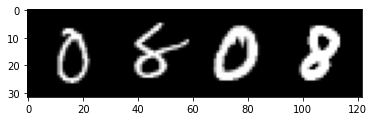

In [6]:
# Plot some sample test data
example_loader = th.utils.data.DataLoader(test_set, shuffle=True, batch_size=4, num_workers=0)
dataiter = iter(example_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images), norm=False)

### Benchmark data-splitting vs CES data-splitting

In [85]:
from torch.utils.data.sampler import SubsetRandomSampler
num_workers = 0

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# MNIST is a simple dataset, hence we only take 300 inlier data to demonstrate
# Benchmark data splitting: equally split the data into 3 sets
n_full = len(train_set)
#n_data = 300
n_data = n_train_bm + n_val_bm + n_cal_bm
n_train_bm = 100
n_val_bm = 100
n_cal_bm = 100

train_set_bm, val_set_bm, cal_set_bm, _ = th.utils.data.random_split(train_set,\
                                 [n_train_bm, n_val_bm, n_cal_bm, n_full-n_data])

# CES data splitting: calibration set is not needed, merge back to the training set
n_train_ces = 200
n_val_ces = 100

train_set_ces, val_set_ces, _ = th.utils.data.random_split(train_set,\
                                 [n_train_ces, n_val_ces, n_full-n_data])


In [86]:
# Create data loader objects
# For benchmarks
batch_size = 10
num_workers = 0

train_loader_bm = th.utils.data.DataLoader(train_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

val_loader_bm = th.utils.data.DataLoader(val_set_bm, batch_size=n_val_bm,
                                          num_workers=num_workers)

cal_loader_bm = th.utils.data.DataLoader(cal_set_bm, batch_size=n_cal_bm,
                                          num_workers=num_workers)

# For CES
train_loader_ces = th.utils.data.DataLoader(train_set_ces, batch_size=batch_size,
                                          num_workers=num_workers)

val_loader_ces = th.utils.data.DataLoader(val_set_ces, batch_size=n_val_ces,
                                          num_workers=num_workers)

In [87]:
# Test loader

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

n_test_samples = 1800
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_loader = th.utils.data.DataLoader(test_set, batch_size=n_test_samples, sampler=test_sampler,
                                         num_workers=num_workers)

# get all test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

### Define Autoencoder

In [88]:
from method import CES_oneClass
from networks import ConvAutoencoder
import torch.optim as optim

# Define the model parameters

lr = 0.1
n_epoch = 200

# Create loss and optimizer
# CES_oneClass object will assume criterion takes three parameters: output, input and target, 
# create wrapper function to modify the criterion.
net_bm = ConvAutoencoder()
Loss = th.nn.MSELoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, inputs)
optimizer_bm = optim.Adam(net_bm.parameters(), lr=lr)

In [89]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

### Train benchmark models and compute conformal p-values

In [90]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_oc_bm = CES_oneClass(net_bm, device, train_loader_bm, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_bm, criterion=criterion,optimizer=optimizer_bm)

===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 200
learning_rate= 0.1


In [91]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_oc_bm.full_train(save_dir = './models/oneClass/benchmarks', save_every = save_every)

Epoch 1 of 200, 10% 	 train_loss: 0.21  took: 0.06s
Epoch 1 of 200, 20% 	 train_loss: 0.16  took: 0.03s
Epoch 1 of 200, 30% 	 train_loss: 0.11  took: 0.03s
Epoch 1 of 200, 40% 	 train_loss: 0.15  took: 0.03s
Epoch 1 of 200, 50% 	 train_loss: 0.09  took: 0.05s
Epoch 1 of 200, 60% 	 train_loss: 0.10  took: 0.07s
Epoch 1 of 200, 70% 	 train_loss: 0.10  took: 0.03s
Epoch 1 of 200, 80% 	 train_loss: 0.09  took: 0.05s
Epoch 1 of 200, 90% 	 train_loss: 0.09  took: 0.03s
Epoch 1 of 200, 100% 	 train_loss: 0.08  took: 0.03s
val_loss = 0.08
Snapshot saved at epoch 1.
Epoch 2 of 200, 10% 	 train_loss: 0.08  took: 0.04s
Epoch 2 of 200, 20% 	 train_loss: 0.07  took: 0.03s
Epoch 2 of 200, 30% 	 train_loss: 0.06  took: 0.03s
Epoch 2 of 200, 40% 	 train_loss: 0.06  took: 0.03s
Epoch 2 of 200, 50% 	 train_loss: 0.06  took: 0.03s
Epoch 2 of 200, 60% 	 train_loss: 0.06  took: 0.03s
Epoch 2 of 200, 70% 	 train_loss: 0.06  took: 0.03s
Epoch 2 of 200, 80% 	 train_loss: 0.06  took: 0.05s
Epoch 2 of 200, 90% 

Epoch 15 of 200, 80% 	 train_loss: 0.06  took: 0.04s
Epoch 15 of 200, 90% 	 train_loss: 0.05  took: 0.02s
Epoch 15 of 200, 100% 	 train_loss: 0.05  took: 0.03s
val_loss = 0.06
Snapshot saved at epoch 15.
Epoch 16 of 200, 10% 	 train_loss: 0.05  took: 0.03s
Epoch 16 of 200, 20% 	 train_loss: 0.06  took: 0.03s
Epoch 16 of 200, 30% 	 train_loss: 0.06  took: 0.03s
Epoch 16 of 200, 40% 	 train_loss: 0.05  took: 0.03s
Epoch 16 of 200, 50% 	 train_loss: 0.06  took: 0.02s
Epoch 16 of 200, 60% 	 train_loss: 0.06  took: 0.01s
Epoch 16 of 200, 70% 	 train_loss: 0.05  took: 0.03s
Epoch 16 of 200, 80% 	 train_loss: 0.06  took: 0.02s
Epoch 16 of 200, 90% 	 train_loss: 0.05  took: 0.05s
Epoch 16 of 200, 100% 	 train_loss: 0.05  took: 0.03s
val_loss = 0.06
Snapshot saved at epoch 16.
Epoch 17 of 200, 10% 	 train_loss: 0.05  took: 0.02s
Epoch 17 of 200, 20% 	 train_loss: 0.06  took: 0.02s
Epoch 17 of 200, 30% 	 train_loss: 0.06  took: 0.02s
Epoch 17 of 200, 40% 	 train_loss: 0.05  took: 0.03s
Epoch 17 

val_loss = 0.05
Snapshot saved at epoch 29.
Epoch 30 of 200, 10% 	 train_loss: 0.05  took: 0.02s
Epoch 30 of 200, 20% 	 train_loss: 0.05  took: 0.03s
Epoch 30 of 200, 30% 	 train_loss: 0.05  took: 0.03s
Epoch 30 of 200, 40% 	 train_loss: 0.05  took: 0.03s
Epoch 30 of 200, 50% 	 train_loss: 0.05  took: 0.03s
Epoch 30 of 200, 60% 	 train_loss: 0.05  took: 0.02s
Epoch 30 of 200, 70% 	 train_loss: 0.05  took: 0.03s
Epoch 30 of 200, 80% 	 train_loss: 0.05  took: 0.04s
Epoch 30 of 200, 90% 	 train_loss: 0.05  took: 0.03s
Epoch 30 of 200, 100% 	 train_loss: 0.05  took: 0.03s
val_loss = 0.05
Snapshot saved at epoch 30.
Epoch 31 of 200, 10% 	 train_loss: 0.05  took: 0.02s
Epoch 31 of 200, 20% 	 train_loss: 0.05  took: 0.03s
Epoch 31 of 200, 30% 	 train_loss: 0.05  took: 0.03s
Epoch 31 of 200, 40% 	 train_loss: 0.05  took: 0.02s
Epoch 31 of 200, 50% 	 train_loss: 0.05  took: 0.02s
Epoch 31 of 200, 60% 	 train_loss: 0.05  took: 0.05s
Epoch 31 of 200, 70% 	 train_loss: 0.05  took: 0.03s
Epoch 31 o

Epoch 44 of 200, 70% 	 train_loss: 0.05  took: 0.05s
Epoch 44 of 200, 80% 	 train_loss: 0.04  took: 0.04s
Epoch 44 of 200, 90% 	 train_loss: 0.04  took: 0.02s
Epoch 44 of 200, 100% 	 train_loss: 0.04  took: 0.02s
val_loss = 0.04
Snapshot saved at epoch 44.
Epoch 45 of 200, 10% 	 train_loss: 0.04  took: 0.05s
Epoch 45 of 200, 20% 	 train_loss: 0.04  took: 0.03s
Epoch 45 of 200, 30% 	 train_loss: 0.04  took: 0.02s
Epoch 45 of 200, 40% 	 train_loss: 0.04  took: 0.02s
Epoch 45 of 200, 50% 	 train_loss: 0.04  took: 0.01s
Epoch 45 of 200, 60% 	 train_loss: 0.04  took: 0.02s
Epoch 45 of 200, 70% 	 train_loss: 0.04  took: 0.03s
Epoch 45 of 200, 80% 	 train_loss: 0.04  took: 0.03s
Epoch 45 of 200, 90% 	 train_loss: 0.04  took: 0.03s
Epoch 45 of 200, 100% 	 train_loss: 0.04  took: 0.03s
val_loss = 0.04
Snapshot saved at epoch 45.
Epoch 46 of 200, 10% 	 train_loss: 0.04  took: 0.05s
Epoch 46 of 200, 20% 	 train_loss: 0.04  took: 0.03s
Epoch 46 of 200, 30% 	 train_loss: 0.04  took: 0.03s
Epoch 46 

Epoch 59 of 200, 10% 	 train_loss: 0.03  took: 0.04s
Epoch 59 of 200, 20% 	 train_loss: 0.03  took: 0.03s
Epoch 59 of 200, 30% 	 train_loss: 0.04  took: 0.03s
Epoch 59 of 200, 40% 	 train_loss: 0.03  took: 0.03s
Epoch 59 of 200, 50% 	 train_loss: 0.03  took: 0.03s
Epoch 59 of 200, 60% 	 train_loss: 0.03  took: 0.03s
Epoch 59 of 200, 70% 	 train_loss: 0.03  took: 0.02s
Epoch 59 of 200, 80% 	 train_loss: 0.03  took: 0.05s
Epoch 59 of 200, 90% 	 train_loss: 0.03  took: 0.03s
Epoch 59 of 200, 100% 	 train_loss: 0.03  took: 0.01s
val_loss = 0.03
Snapshot saved at epoch 59.
Epoch 60 of 200, 10% 	 train_loss: 0.03  took: 0.03s
Epoch 60 of 200, 20% 	 train_loss: 0.03  took: 0.05s
Epoch 60 of 200, 30% 	 train_loss: 0.04  took: 0.03s
Epoch 60 of 200, 40% 	 train_loss: 0.03  took: 0.02s
Epoch 60 of 200, 50% 	 train_loss: 0.03  took: 0.01s
Epoch 60 of 200, 60% 	 train_loss: 0.03  took: 0.03s
Epoch 60 of 200, 70% 	 train_loss: 0.03  took: 0.02s
Epoch 60 of 200, 80% 	 train_loss: 0.03  took: 0.02s
E

val_loss = 0.03
Snapshot saved at epoch 73.
Epoch 74 of 200, 10% 	 train_loss: 0.03  took: 0.03s
Epoch 74 of 200, 20% 	 train_loss: 0.03  took: 0.03s
Epoch 74 of 200, 30% 	 train_loss: 0.03  took: 0.03s
Epoch 74 of 200, 40% 	 train_loss: 0.03  took: 0.03s
Epoch 74 of 200, 50% 	 train_loss: 0.03  took: 0.03s
Epoch 74 of 200, 60% 	 train_loss: 0.03  took: 0.03s
Epoch 74 of 200, 70% 	 train_loss: 0.03  took: 0.03s
Epoch 74 of 200, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 74 of 200, 90% 	 train_loss: 0.03  took: 0.03s
Epoch 74 of 200, 100% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.03
Snapshot saved at epoch 74.
Epoch 75 of 200, 10% 	 train_loss: 0.03  took: 0.05s
Epoch 75 of 200, 20% 	 train_loss: 0.03  took: 0.04s
Epoch 75 of 200, 30% 	 train_loss: 0.03  took: 0.03s
Epoch 75 of 200, 40% 	 train_loss: 0.03  took: 0.03s
Epoch 75 of 200, 50% 	 train_loss: 0.03  took: 0.03s
Epoch 75 of 200, 60% 	 train_loss: 0.03  took: 0.02s
Epoch 75 of 200, 70% 	 train_loss: 0.03  took: 0.03s
Epoch 75 o

Epoch 88 of 200, 80% 	 train_loss: 0.03  took: 0.05s
Epoch 88 of 200, 90% 	 train_loss: 0.03  took: 0.03s
Epoch 88 of 200, 100% 	 train_loss: 0.03  took: 0.02s
val_loss = 0.03
Snapshot saved at epoch 88.
Epoch 89 of 200, 10% 	 train_loss: 0.03  took: 0.02s
Epoch 89 of 200, 20% 	 train_loss: 0.03  took: 0.02s
Epoch 89 of 200, 30% 	 train_loss: 0.03  took: 0.02s
Epoch 89 of 200, 40% 	 train_loss: 0.03  took: 0.02s
Epoch 89 of 200, 50% 	 train_loss: 0.03  took: 0.02s
Epoch 89 of 200, 60% 	 train_loss: 0.03  took: 0.02s
Epoch 89 of 200, 70% 	 train_loss: 0.03  took: 0.02s
Epoch 89 of 200, 80% 	 train_loss: 0.03  took: 0.02s
Epoch 89 of 200, 90% 	 train_loss: 0.03  took: 0.02s
Epoch 89 of 200, 100% 	 train_loss: 0.03  took: 0.02s
val_loss = 0.03
Snapshot saved at epoch 89.
Epoch 90 of 200, 10% 	 train_loss: 0.03  took: 0.02s
Epoch 90 of 200, 20% 	 train_loss: 0.03  took: 0.02s
Epoch 90 of 200, 30% 	 train_loss: 0.04  took: 0.02s
Epoch 90 of 200, 40% 	 train_loss: 0.03  took: 0.02s
Epoch 90 

Epoch 103 of 200, 30% 	 train_loss: 0.03  took: 0.04s
Epoch 103 of 200, 40% 	 train_loss: 0.03  took: 0.03s
Epoch 103 of 200, 50% 	 train_loss: 0.03  took: 0.02s
Epoch 103 of 200, 60% 	 train_loss: 0.03  took: 0.02s
Epoch 103 of 200, 70% 	 train_loss: 0.03  took: 0.03s
Epoch 103 of 200, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 103 of 200, 90% 	 train_loss: 0.03  took: 0.05s
Epoch 103 of 200, 100% 	 train_loss: 0.03  took: 0.05s
val_loss = 0.03
Snapshot saved at epoch 103.
Epoch 104 of 200, 10% 	 train_loss: 0.03  took: 0.02s
Epoch 104 of 200, 20% 	 train_loss: 0.03  took: 0.02s
Epoch 104 of 200, 30% 	 train_loss: 0.03  took: 0.02s
Epoch 104 of 200, 40% 	 train_loss: 0.03  took: 0.03s
Epoch 104 of 200, 50% 	 train_loss: 0.03  took: 0.03s
Epoch 104 of 200, 60% 	 train_loss: 0.03  took: 0.03s
Epoch 104 of 200, 70% 	 train_loss: 0.03  took: 0.03s
Epoch 104 of 200, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 104 of 200, 90% 	 train_loss: 0.03  took: 0.03s
Epoch 104 of 200, 100% 	 train_loss:

Epoch 117 of 200, 40% 	 train_loss: 0.03  took: 0.02s
Epoch 117 of 200, 50% 	 train_loss: 0.03  took: 0.02s
Epoch 117 of 200, 60% 	 train_loss: 0.03  took: 0.03s
Epoch 117 of 200, 70% 	 train_loss: 0.03  took: 0.03s
Epoch 117 of 200, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 117 of 200, 90% 	 train_loss: 0.03  took: 0.03s
Epoch 117 of 200, 100% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.03
Snapshot saved at epoch 117.
Epoch 118 of 200, 10% 	 train_loss: 0.03  took: 0.04s
Epoch 118 of 200, 20% 	 train_loss: 0.03  took: 0.05s
Epoch 118 of 200, 30% 	 train_loss: 0.03  took: 0.03s
Epoch 118 of 200, 40% 	 train_loss: 0.03  took: 0.03s
Epoch 118 of 200, 50% 	 train_loss: 0.03  took: 0.03s
Epoch 118 of 200, 60% 	 train_loss: 0.03  took: 0.04s
Epoch 118 of 200, 70% 	 train_loss: 0.03  took: 0.03s
Epoch 118 of 200, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 118 of 200, 90% 	 train_loss: 0.03  took: 0.03s
Epoch 118 of 200, 100% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.03
Snapshot saved at e

Epoch 131 of 200, 50% 	 train_loss: 0.03  took: 0.02s
Epoch 131 of 200, 60% 	 train_loss: 0.03  took: 0.02s
Epoch 131 of 200, 70% 	 train_loss: 0.03  took: 0.02s
Epoch 131 of 200, 80% 	 train_loss: 0.03  took: 0.02s
Epoch 131 of 200, 90% 	 train_loss: 0.03  took: 0.02s
Epoch 131 of 200, 100% 	 train_loss: 0.03  took: 0.02s
val_loss = 0.03
Snapshot saved at epoch 131.
Epoch 132 of 200, 10% 	 train_loss: 0.03  took: 0.02s
Epoch 132 of 200, 20% 	 train_loss: 0.03  took: 0.02s
Epoch 132 of 200, 30% 	 train_loss: 0.03  took: 0.02s
Epoch 132 of 200, 40% 	 train_loss: 0.03  took: 0.02s
Epoch 132 of 200, 50% 	 train_loss: 0.03  took: 0.02s
Epoch 132 of 200, 60% 	 train_loss: 0.03  took: 0.02s
Epoch 132 of 200, 70% 	 train_loss: 0.03  took: 0.02s
Epoch 132 of 200, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 132 of 200, 90% 	 train_loss: 0.03  took: 0.03s
Epoch 132 of 200, 100% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.03
Snapshot saved at epoch 132.
Epoch 133 of 200, 10% 	 train_loss: 0.03  to

Epoch 145 of 200, 90% 	 train_loss: 0.03  took: 0.05s
Epoch 145 of 200, 100% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.03
Snapshot saved at epoch 145.
Epoch 146 of 200, 10% 	 train_loss: 0.03  took: 0.02s
Epoch 146 of 200, 20% 	 train_loss: 0.03  took: 0.03s
Epoch 146 of 200, 30% 	 train_loss: 0.03  took: 0.02s
Epoch 146 of 200, 40% 	 train_loss: 0.03  took: 0.03s
Epoch 146 of 200, 50% 	 train_loss: 0.03  took: 0.03s
Epoch 146 of 200, 60% 	 train_loss: 0.03  took: 0.04s
Epoch 146 of 200, 70% 	 train_loss: 0.03  took: 0.03s
Epoch 146 of 200, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 146 of 200, 90% 	 train_loss: 0.03  took: 0.03s
Epoch 146 of 200, 100% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.03
Snapshot saved at epoch 146.
Epoch 147 of 200, 10% 	 train_loss: 0.03  took: 0.03s
Epoch 147 of 200, 20% 	 train_loss: 0.03  took: 0.05s
Epoch 147 of 200, 30% 	 train_loss: 0.03  took: 0.03s
Epoch 147 of 200, 40% 	 train_loss: 0.03  took: 0.03s
Epoch 147 of 200, 50% 	 train_loss: 0.03  to

Epoch 160 of 200, 20% 	 train_loss: 0.03  took: 0.04s
Epoch 160 of 200, 30% 	 train_loss: 0.03  took: 0.02s
Epoch 160 of 200, 40% 	 train_loss: 0.03  took: 0.03s
Epoch 160 of 200, 50% 	 train_loss: 0.03  took: 0.03s
Epoch 160 of 200, 60% 	 train_loss: 0.03  took: 0.02s
Epoch 160 of 200, 70% 	 train_loss: 0.03  took: 0.02s
Epoch 160 of 200, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 160 of 200, 90% 	 train_loss: 0.03  took: 0.02s
Epoch 160 of 200, 100% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.03
Snapshot saved at epoch 160.
Epoch 161 of 200, 10% 	 train_loss: 0.03  took: 0.03s
Epoch 161 of 200, 20% 	 train_loss: 0.03  took: 0.02s
Epoch 161 of 200, 30% 	 train_loss: 0.03  took: 0.02s
Epoch 161 of 200, 40% 	 train_loss: 0.03  took: 0.02s
Epoch 161 of 200, 50% 	 train_loss: 0.03  took: 0.02s
Epoch 161 of 200, 60% 	 train_loss: 0.03  took: 0.02s
Epoch 161 of 200, 70% 	 train_loss: 0.03  took: 0.02s
Epoch 161 of 200, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 161 of 200, 90% 	 train_loss: 

Epoch 174 of 200, 40% 	 train_loss: 0.03  took: 0.04s
Epoch 174 of 200, 50% 	 train_loss: 0.03  took: 0.02s
Epoch 174 of 200, 60% 	 train_loss: 0.03  took: 0.06s
Epoch 174 of 200, 70% 	 train_loss: 0.03  took: 0.03s
Epoch 174 of 200, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 174 of 200, 90% 	 train_loss: 0.03  took: 0.05s
Epoch 174 of 200, 100% 	 train_loss: 0.03  took: 0.04s
val_loss = 0.03
Snapshot saved at epoch 174.
Epoch 175 of 200, 10% 	 train_loss: 0.03  took: 0.03s
Epoch 175 of 200, 20% 	 train_loss: 0.03  took: 0.03s
Epoch 175 of 200, 30% 	 train_loss: 0.03  took: 0.03s
Epoch 175 of 200, 40% 	 train_loss: 0.03  took: 0.05s
Epoch 175 of 200, 50% 	 train_loss: 0.03  took: 0.03s
Epoch 175 of 200, 60% 	 train_loss: 0.03  took: 0.03s
Epoch 175 of 200, 70% 	 train_loss: 0.03  took: 0.03s
Epoch 175 of 200, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 175 of 200, 90% 	 train_loss: 0.03  took: 0.03s
Epoch 175 of 200, 100% 	 train_loss: 0.03  took: 0.05s
val_loss = 0.03
Snapshot saved at e

Epoch 188 of 200, 100% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.03
Snapshot saved at epoch 188.
Epoch 189 of 200, 10% 	 train_loss: 0.03  took: 0.07s
Epoch 189 of 200, 20% 	 train_loss: 0.03  took: 0.02s
Epoch 189 of 200, 30% 	 train_loss: 0.03  took: 0.03s
Epoch 189 of 200, 40% 	 train_loss: 0.03  took: 0.02s
Epoch 189 of 200, 50% 	 train_loss: 0.03  took: 0.03s
Epoch 189 of 200, 60% 	 train_loss: 0.03  took: 0.03s
Epoch 189 of 200, 70% 	 train_loss: 0.03  took: 0.04s
Epoch 189 of 200, 80% 	 train_loss: 0.03  took: 0.03s
Epoch 189 of 200, 90% 	 train_loss: 0.03  took: 0.03s
Epoch 189 of 200, 100% 	 train_loss: 0.03  took: 0.03s
val_loss = 0.03
Snapshot saved at epoch 189.
Epoch 190 of 200, 10% 	 train_loss: 0.03  took: 0.05s
Epoch 190 of 200, 20% 	 train_loss: 0.03  took: 0.03s
Epoch 190 of 200, 30% 	 train_loss: 0.03  took: 0.02s
Epoch 190 of 200, 40% 	 train_loss: 0.03  took: 0.05s
Epoch 190 of 200, 50% 	 train_loss: 0.03  took: 0.03s
Epoch 190 of 200, 60% 	 train_loss: 0.03  to

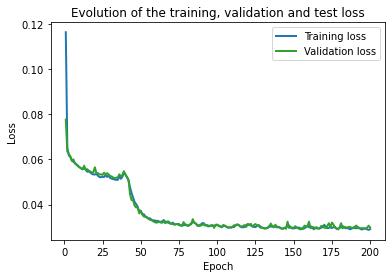

In [92]:
plot_loss(CES_oc_bm.train_loss_history, CES_oc_bm.val_loss_history)

In [93]:
import time

# Pick the best model for each test point
start = time.time()
best_loss_bm, best_model_bm, val_loss_history_bm = CES_oc_bm.select_model()
print('The best model for the benchmark is stored at:', best_model_bm)
print('selecting models takes:', time.time()-start)

The best model for the benchmark is stored at: ./models/oneClass/benchmarks\model179.pth
selecting models takes: 0.0


In [94]:
from inference import Conformal_PVals

model_list_bm = CES_oc_bm.model_list

# Compute conformity scores of calibration sets for each model
# this initialization will be a one-time effort.
cal_time = time.time()
C_PVals_bm = Conformal_PVals(net_bm, device, cal_loader_bm, model_list_bm, random_state = 0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 15.82it/s]

Initialization done!
Calibration (one time effort) takes:12.65s.


In [95]:
pvals_bm = C_PVals_bm.compute_pvals(inputs, [best_model_bm]*len(inputs))

100%|█████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:05<00:00, 332.46it/s]

Finished computing p-values for 1800 test points.


Average p-value for inliers is 0.499172, average p-value for outliers is 0.210420.


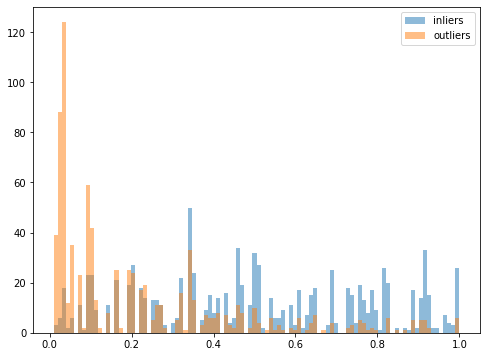

In [96]:
plot_pvals(pvals_bm, labels)

In [97]:
fdp, power = evaluate_bh(pvals_bm, labels, alpha=0.1)
print('Apply BH procedure yields FDP {:3f}, power {:3f}.'.format(fdp,power))

Apply BH procedure yields FDP 0.015000, power 0.306098.


### Train with CES data splitting and apply CES method

In [98]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

net_ces = ConvAutoencoder()
Loss = th.nn.MSELoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, inputs)
optimizer_ces = optim.Adam(net_ces.parameters(), lr=lr)


# Initialize the CES class with model parameters
CES_oc_ces = CES_oneClass(net_ces, device, train_loader_ces, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_ces, criterion=criterion,optimizer=optimizer_ces)

===== HYPERPARAMETERS =====
batch_size= 10
n_epochs= 200
learning_rate= 0.1


In [99]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_oc_ces.full_train(save_dir = './models/oneClass/ces', save_every = save_every)

Epoch 1 of 200, 10% 	 train_loss: 0.16  took: 0.08s
Epoch 1 of 200, 20% 	 train_loss: 0.13  took: 0.06s
Epoch 1 of 200, 30% 	 train_loss: 0.11  took: 0.06s
Epoch 1 of 200, 40% 	 train_loss: 0.10  took: 0.06s
Epoch 1 of 200, 50% 	 train_loss: 0.08  took: 0.07s
Epoch 1 of 200, 60% 	 train_loss: 0.07  took: 0.07s
Epoch 1 of 200, 70% 	 train_loss: 0.06  took: 0.06s
Epoch 1 of 200, 80% 	 train_loss: 0.05  took: 0.07s
Epoch 1 of 200, 90% 	 train_loss: 0.05  took: 0.05s
Epoch 1 of 200, 100% 	 train_loss: 0.04  took: 0.07s
val_loss = 0.04
Snapshot saved at epoch 1.
Epoch 2 of 200, 10% 	 train_loss: 0.05  took: 0.05s
Epoch 2 of 200, 20% 	 train_loss: 0.04  took: 0.03s
Epoch 2 of 200, 30% 	 train_loss: 0.04  took: 0.06s
Epoch 2 of 200, 40% 	 train_loss: 0.04  took: 0.06s
Epoch 2 of 200, 50% 	 train_loss: 0.04  took: 0.06s
Epoch 2 of 200, 60% 	 train_loss: 0.04  took: 0.05s
Epoch 2 of 200, 70% 	 train_loss: 0.03  took: 0.08s
Epoch 2 of 200, 80% 	 train_loss: 0.03  took: 0.07s
Epoch 2 of 200, 90% 

Epoch 15 of 200, 80% 	 train_loss: 0.01  took: 0.04s
Epoch 15 of 200, 90% 	 train_loss: 0.01  took: 0.06s
Epoch 15 of 200, 100% 	 train_loss: 0.02  took: 0.06s
val_loss = 0.01
Snapshot saved at epoch 15.
Epoch 16 of 200, 10% 	 train_loss: 0.01  took: 0.06s
Epoch 16 of 200, 20% 	 train_loss: 0.01  took: 0.06s
Epoch 16 of 200, 30% 	 train_loss: 0.01  took: 0.06s
Epoch 16 of 200, 40% 	 train_loss: 0.02  took: 0.08s
Epoch 16 of 200, 50% 	 train_loss: 0.02  took: 0.06s
Epoch 16 of 200, 60% 	 train_loss: 0.01  took: 0.05s
Epoch 16 of 200, 70% 	 train_loss: 0.02  took: 0.04s
Epoch 16 of 200, 80% 	 train_loss: 0.01  took: 0.04s
Epoch 16 of 200, 90% 	 train_loss: 0.01  took: 0.04s
Epoch 16 of 200, 100% 	 train_loss: 0.02  took: 0.04s
val_loss = 0.01
Snapshot saved at epoch 16.
Epoch 17 of 200, 10% 	 train_loss: 0.01  took: 0.04s
Epoch 17 of 200, 20% 	 train_loss: 0.01  took: 0.04s
Epoch 17 of 200, 30% 	 train_loss: 0.01  took: 0.05s
Epoch 17 of 200, 40% 	 train_loss: 0.02  took: 0.06s
Epoch 17 

Epoch 30 of 200, 20% 	 train_loss: 0.01  took: 0.06s
Epoch 30 of 200, 30% 	 train_loss: 0.01  took: 0.06s
Epoch 30 of 200, 40% 	 train_loss: 0.01  took: 0.03s
Epoch 30 of 200, 50% 	 train_loss: 0.02  took: 0.05s
Epoch 30 of 200, 60% 	 train_loss: 0.01  took: 0.07s
Epoch 30 of 200, 70% 	 train_loss: 0.01  took: 0.06s
Epoch 30 of 200, 80% 	 train_loss: 0.01  took: 0.06s
Epoch 30 of 200, 90% 	 train_loss: 0.01  took: 0.06s
Epoch 30 of 200, 100% 	 train_loss: 0.01  took: 0.07s
val_loss = 0.01
Snapshot saved at epoch 30.
Epoch 31 of 200, 10% 	 train_loss: 0.01  took: 0.07s
Epoch 31 of 200, 20% 	 train_loss: 0.01  took: 0.05s
Epoch 31 of 200, 30% 	 train_loss: 0.01  took: 0.06s
Epoch 31 of 200, 40% 	 train_loss: 0.01  took: 0.06s
Epoch 31 of 200, 50% 	 train_loss: 0.02  took: 0.05s
Epoch 31 of 200, 60% 	 train_loss: 0.01  took: 0.06s
Epoch 31 of 200, 70% 	 train_loss: 0.01  took: 0.05s
Epoch 31 of 200, 80% 	 train_loss: 0.01  took: 0.04s
Epoch 31 of 200, 90% 	 train_loss: 0.01  took: 0.03s
E

Epoch 44 of 200, 70% 	 train_loss: 0.01  took: 0.06s
Epoch 44 of 200, 80% 	 train_loss: 0.01  took: 0.05s
Epoch 44 of 200, 90% 	 train_loss: 0.01  took: 0.06s
Epoch 44 of 200, 100% 	 train_loss: 0.01  took: 0.06s
val_loss = 0.01
Snapshot saved at epoch 44.
Epoch 45 of 200, 10% 	 train_loss: 0.01  took: 0.05s
Epoch 45 of 200, 20% 	 train_loss: 0.01  took: 0.06s
Epoch 45 of 200, 30% 	 train_loss: 0.01  took: 0.06s
Epoch 45 of 200, 40% 	 train_loss: 0.01  took: 0.06s
Epoch 45 of 200, 50% 	 train_loss: 0.02  took: 0.06s
Epoch 45 of 200, 60% 	 train_loss: 0.01  took: 0.05s
Epoch 45 of 200, 70% 	 train_loss: 0.01  took: 0.05s
Epoch 45 of 200, 80% 	 train_loss: 0.01  took: 0.07s
Epoch 45 of 200, 90% 	 train_loss: 0.01  took: 0.07s
Epoch 45 of 200, 100% 	 train_loss: 0.01  took: 0.06s
val_loss = 0.01
Snapshot saved at epoch 45.
Epoch 46 of 200, 10% 	 train_loss: 0.01  took: 0.07s
Epoch 46 of 200, 20% 	 train_loss: 0.01  took: 0.04s
Epoch 46 of 200, 30% 	 train_loss: 0.01  took: 0.08s
Epoch 46 

val_loss = 0.01
Snapshot saved at epoch 58.
Epoch 59 of 200, 10% 	 train_loss: 0.01  took: 0.04s
Epoch 59 of 200, 20% 	 train_loss: 0.01  took: 0.06s
Epoch 59 of 200, 30% 	 train_loss: 0.01  took: 0.05s
Epoch 59 of 200, 40% 	 train_loss: 0.01  took: 0.07s
Epoch 59 of 200, 50% 	 train_loss: 0.01  took: 0.06s
Epoch 59 of 200, 60% 	 train_loss: 0.01  took: 0.06s
Epoch 59 of 200, 70% 	 train_loss: 0.01  took: 0.06s
Epoch 59 of 200, 80% 	 train_loss: 0.01  took: 0.06s
Epoch 59 of 200, 90% 	 train_loss: 0.01  took: 0.06s
Epoch 59 of 200, 100% 	 train_loss: 0.01  took: 0.05s
val_loss = 0.01
Snapshot saved at epoch 59.
Epoch 60 of 200, 10% 	 train_loss: 0.01  took: 0.05s
Epoch 60 of 200, 20% 	 train_loss: 0.01  took: 0.06s
Epoch 60 of 200, 30% 	 train_loss: 0.01  took: 0.05s
Epoch 60 of 200, 40% 	 train_loss: 0.01  took: 0.04s
Epoch 60 of 200, 50% 	 train_loss: 0.01  took: 0.05s
Epoch 60 of 200, 60% 	 train_loss: 0.01  took: 0.07s
Epoch 60 of 200, 70% 	 train_loss: 0.01  took: 0.03s
Epoch 60 o

Epoch 73 of 200, 60% 	 train_loss: 0.01  took: 0.09s
Epoch 73 of 200, 70% 	 train_loss: 0.01  took: 0.06s
Epoch 73 of 200, 80% 	 train_loss: 0.01  took: 0.06s
Epoch 73 of 200, 90% 	 train_loss: 0.01  took: 0.06s
Epoch 73 of 200, 100% 	 train_loss: 0.01  took: 0.05s
val_loss = 0.01
Snapshot saved at epoch 73.
Epoch 74 of 200, 10% 	 train_loss: 0.01  took: 0.08s
Epoch 74 of 200, 20% 	 train_loss: 0.01  took: 0.07s
Epoch 74 of 200, 30% 	 train_loss: 0.01  took: 0.06s
Epoch 74 of 200, 40% 	 train_loss: 0.01  took: 0.06s
Epoch 74 of 200, 50% 	 train_loss: 0.01  took: 0.05s
Epoch 74 of 200, 60% 	 train_loss: 0.01  took: 0.05s
Epoch 74 of 200, 70% 	 train_loss: 0.01  took: 0.04s
Epoch 74 of 200, 80% 	 train_loss: 0.01  took: 0.04s
Epoch 74 of 200, 90% 	 train_loss: 0.01  took: 0.03s
Epoch 74 of 200, 100% 	 train_loss: 0.01  took: 0.05s
val_loss = 0.01
Snapshot saved at epoch 74.
Epoch 75 of 200, 10% 	 train_loss: 0.01  took: 0.05s
Epoch 75 of 200, 20% 	 train_loss: 0.01  took: 0.05s
Epoch 75 

val_loss = 0.01
Snapshot saved at epoch 87.
Epoch 88 of 200, 10% 	 train_loss: 0.01  took: 0.05s
Epoch 88 of 200, 20% 	 train_loss: 0.01  took: 0.06s
Epoch 88 of 200, 30% 	 train_loss: 0.01  took: 0.06s
Epoch 88 of 200, 40% 	 train_loss: 0.01  took: 0.07s
Epoch 88 of 200, 50% 	 train_loss: 0.02  took: 0.04s
Epoch 88 of 200, 60% 	 train_loss: 0.01  took: 0.04s
Epoch 88 of 200, 70% 	 train_loss: 0.01  took: 0.03s
Epoch 88 of 200, 80% 	 train_loss: 0.01  took: 0.03s
Epoch 88 of 200, 90% 	 train_loss: 0.01  took: 0.04s
Epoch 88 of 200, 100% 	 train_loss: 0.01  took: 0.04s
val_loss = 0.01
Snapshot saved at epoch 88.
Epoch 89 of 200, 10% 	 train_loss: 0.01  took: 0.04s
Epoch 89 of 200, 20% 	 train_loss: 0.01  took: 0.04s
Epoch 89 of 200, 30% 	 train_loss: 0.01  took: 0.04s
Epoch 89 of 200, 40% 	 train_loss: 0.01  took: 0.04s
Epoch 89 of 200, 50% 	 train_loss: 0.02  took: 0.06s
Epoch 89 of 200, 60% 	 train_loss: 0.01  took: 0.07s
Epoch 89 of 200, 70% 	 train_loss: 0.01  took: 0.06s
Epoch 89 o

Epoch 102 of 200, 30% 	 train_loss: 0.01  took: 0.06s
Epoch 102 of 200, 40% 	 train_loss: 0.01  took: 0.08s
Epoch 102 of 200, 50% 	 train_loss: 0.01  took: 0.06s
Epoch 102 of 200, 60% 	 train_loss: 0.01  took: 0.05s
Epoch 102 of 200, 70% 	 train_loss: 0.01  took: 0.06s
Epoch 102 of 200, 80% 	 train_loss: 0.01  took: 0.06s
Epoch 102 of 200, 90% 	 train_loss: 0.01  took: 0.05s
Epoch 102 of 200, 100% 	 train_loss: 0.01  took: 0.06s
val_loss = 0.01
Snapshot saved at epoch 102.
Epoch 103 of 200, 10% 	 train_loss: 0.01  took: 0.05s
Epoch 103 of 200, 20% 	 train_loss: 0.01  took: 0.06s
Epoch 103 of 200, 30% 	 train_loss: 0.01  took: 0.06s
Epoch 103 of 200, 40% 	 train_loss: 0.01  took: 0.07s
Epoch 103 of 200, 50% 	 train_loss: 0.01  took: 0.06s
Epoch 103 of 200, 60% 	 train_loss: 0.01  took: 0.08s
Epoch 103 of 200, 70% 	 train_loss: 0.01  took: 0.06s
Epoch 103 of 200, 80% 	 train_loss: 0.01  took: 0.08s
Epoch 103 of 200, 90% 	 train_loss: 0.01  took: 0.06s
Epoch 103 of 200, 100% 	 train_loss:

Epoch 116 of 200, 50% 	 train_loss: 0.01  took: 0.08s
Epoch 116 of 200, 60% 	 train_loss: 0.01  took: 0.06s
Epoch 116 of 200, 70% 	 train_loss: 0.01  took: 0.05s
Epoch 116 of 200, 80% 	 train_loss: 0.01  took: 0.03s
Epoch 116 of 200, 90% 	 train_loss: 0.01  took: 0.03s
Epoch 116 of 200, 100% 	 train_loss: 0.01  took: 0.06s
val_loss = 0.01
Snapshot saved at epoch 116.
Epoch 117 of 200, 10% 	 train_loss: 0.01  took: 0.06s
Epoch 117 of 200, 20% 	 train_loss: 0.01  took: 0.08s
Epoch 117 of 200, 30% 	 train_loss: 0.01  took: 0.04s
Epoch 117 of 200, 40% 	 train_loss: 0.01  took: 0.06s
Epoch 117 of 200, 50% 	 train_loss: 0.01  took: 0.05s
Epoch 117 of 200, 60% 	 train_loss: 0.01  took: 0.06s
Epoch 117 of 200, 70% 	 train_loss: 0.01  took: 0.08s
Epoch 117 of 200, 80% 	 train_loss: 0.01  took: 0.06s
Epoch 117 of 200, 90% 	 train_loss: 0.01  took: 0.04s
Epoch 117 of 200, 100% 	 train_loss: 0.01  took: 0.06s
val_loss = 0.01
Snapshot saved at epoch 117.
Epoch 118 of 200, 10% 	 train_loss: 0.01  to

Epoch 130 of 200, 60% 	 train_loss: 0.01  took: 0.04s
Epoch 130 of 200, 70% 	 train_loss: 0.01  took: 0.04s
Epoch 130 of 200, 80% 	 train_loss: 0.01  took: 0.04s
Epoch 130 of 200, 90% 	 train_loss: 0.01  took: 0.04s
Epoch 130 of 200, 100% 	 train_loss: 0.01  took: 0.04s
val_loss = 0.01
Snapshot saved at epoch 130.
Epoch 131 of 200, 10% 	 train_loss: 0.01  took: 0.05s
Epoch 131 of 200, 20% 	 train_loss: 0.01  took: 0.06s
Epoch 131 of 200, 30% 	 train_loss: 0.01  took: 0.05s
Epoch 131 of 200, 40% 	 train_loss: 0.01  took: 0.05s
Epoch 131 of 200, 50% 	 train_loss: 0.01  took: 0.05s
Epoch 131 of 200, 60% 	 train_loss: 0.01  took: 0.05s
Epoch 131 of 200, 70% 	 train_loss: 0.01  took: 0.06s
Epoch 131 of 200, 80% 	 train_loss: 0.01  took: 0.05s
Epoch 131 of 200, 90% 	 train_loss: 0.01  took: 0.04s
Epoch 131 of 200, 100% 	 train_loss: 0.01  took: 0.03s
val_loss = 0.02
Snapshot saved at epoch 131.
Epoch 132 of 200, 10% 	 train_loss: 0.01  took: 0.05s
Epoch 132 of 200, 20% 	 train_loss: 0.01  to

Epoch 144 of 200, 70% 	 train_loss: 0.01  took: 0.07s
Epoch 144 of 200, 80% 	 train_loss: 0.01  took: 0.09s
Epoch 144 of 200, 90% 	 train_loss: 0.01  took: 0.09s
Epoch 144 of 200, 100% 	 train_loss: 0.01  took: 0.06s
val_loss = 0.01
Snapshot saved at epoch 144.
Epoch 145 of 200, 10% 	 train_loss: 0.01  took: 0.05s
Epoch 145 of 200, 20% 	 train_loss: 0.01  took: 0.06s
Epoch 145 of 200, 30% 	 train_loss: 0.01  took: 0.05s
Epoch 145 of 200, 40% 	 train_loss: 0.01  took: 0.04s
Epoch 145 of 200, 50% 	 train_loss: 0.01  took: 0.06s
Epoch 145 of 200, 60% 	 train_loss: 0.01  took: 0.03s
Epoch 145 of 200, 70% 	 train_loss: 0.01  took: 0.07s
Epoch 145 of 200, 80% 	 train_loss: 0.01  took: 0.04s
Epoch 145 of 200, 90% 	 train_loss: 0.01  took: 0.05s
Epoch 145 of 200, 100% 	 train_loss: 0.01  took: 0.05s
val_loss = 0.01
Snapshot saved at epoch 145.
Epoch 146 of 200, 10% 	 train_loss: 0.01  took: 0.06s
Epoch 146 of 200, 20% 	 train_loss: 0.01  took: 0.06s
Epoch 146 of 200, 30% 	 train_loss: 0.01  to

Epoch 158 of 200, 100% 	 train_loss: 0.01  took: 0.06s
val_loss = 0.01
Snapshot saved at epoch 158.
Epoch 159 of 200, 10% 	 train_loss: 0.01  took: 0.08s
Epoch 159 of 200, 20% 	 train_loss: 0.01  took: 0.08s
Epoch 159 of 200, 30% 	 train_loss: 0.01  took: 0.06s
Epoch 159 of 200, 40% 	 train_loss: 0.01  took: 0.06s
Epoch 159 of 200, 50% 	 train_loss: 0.01  took: 0.06s
Epoch 159 of 200, 60% 	 train_loss: 0.01  took: 0.06s
Epoch 159 of 200, 70% 	 train_loss: 0.01  took: 0.05s
Epoch 159 of 200, 80% 	 train_loss: 0.01  took: 0.05s
Epoch 159 of 200, 90% 	 train_loss: 0.01  took: 0.05s
Epoch 159 of 200, 100% 	 train_loss: 0.01  took: 0.06s
val_loss = 0.01
Snapshot saved at epoch 159.
Epoch 160 of 200, 10% 	 train_loss: 0.01  took: 0.05s
Epoch 160 of 200, 20% 	 train_loss: 0.01  took: 0.06s
Epoch 160 of 200, 30% 	 train_loss: 0.01  took: 0.05s
Epoch 160 of 200, 40% 	 train_loss: 0.01  took: 0.04s
Epoch 160 of 200, 50% 	 train_loss: 0.01  took: 0.06s
Epoch 160 of 200, 60% 	 train_loss: 0.01  to

val_loss = 0.01
Snapshot saved at epoch 172.
Epoch 173 of 200, 10% 	 train_loss: 0.01  took: 0.04s
Epoch 173 of 200, 20% 	 train_loss: 0.01  took: 0.04s
Epoch 173 of 200, 30% 	 train_loss: 0.01  took: 0.04s
Epoch 173 of 200, 40% 	 train_loss: 0.01  took: 0.04s
Epoch 173 of 200, 50% 	 train_loss: 0.01  took: 0.04s
Epoch 173 of 200, 60% 	 train_loss: 0.01  took: 0.04s
Epoch 173 of 200, 70% 	 train_loss: 0.01  took: 0.05s
Epoch 173 of 200, 80% 	 train_loss: 0.01  took: 0.03s
Epoch 173 of 200, 90% 	 train_loss: 0.01  took: 0.04s
Epoch 173 of 200, 100% 	 train_loss: 0.01  took: 0.04s
val_loss = 0.01
Snapshot saved at epoch 173.
Epoch 174 of 200, 10% 	 train_loss: 0.01  took: 0.04s
Epoch 174 of 200, 20% 	 train_loss: 0.01  took: 0.03s
Epoch 174 of 200, 30% 	 train_loss: 0.01  took: 0.03s
Epoch 174 of 200, 40% 	 train_loss: 0.01  took: 0.06s
Epoch 174 of 200, 50% 	 train_loss: 0.01  took: 0.05s
Epoch 174 of 200, 60% 	 train_loss: 0.01  took: 0.06s
Epoch 174 of 200, 70% 	 train_loss: 0.01  too

Epoch 187 of 200, 10% 	 train_loss: 0.01  took: 0.06s
Epoch 187 of 200, 20% 	 train_loss: 0.01  took: 0.06s
Epoch 187 of 200, 30% 	 train_loss: 0.01  took: 0.05s
Epoch 187 of 200, 40% 	 train_loss: 0.01  took: 0.06s
Epoch 187 of 200, 50% 	 train_loss: 0.01  took: 0.06s
Epoch 187 of 200, 60% 	 train_loss: 0.01  took: 0.06s
Epoch 187 of 200, 70% 	 train_loss: 0.01  took: 0.06s
Epoch 187 of 200, 80% 	 train_loss: 0.01  took: 0.08s
Epoch 187 of 200, 90% 	 train_loss: 0.01  took: 0.08s
Epoch 187 of 200, 100% 	 train_loss: 0.01  took: 0.06s
val_loss = 0.01
Snapshot saved at epoch 187.
Epoch 188 of 200, 10% 	 train_loss: 0.01  took: 0.04s
Epoch 188 of 200, 20% 	 train_loss: 0.01  took: 0.03s
Epoch 188 of 200, 30% 	 train_loss: 0.01  took: 0.05s
Epoch 188 of 200, 40% 	 train_loss: 0.01  took: 0.06s
Epoch 188 of 200, 50% 	 train_loss: 0.01  took: 0.06s
Epoch 188 of 200, 60% 	 train_loss: 0.01  took: 0.06s
Epoch 188 of 200, 70% 	 train_loss: 0.01  took: 0.06s
Epoch 188 of 200, 80% 	 train_loss: 

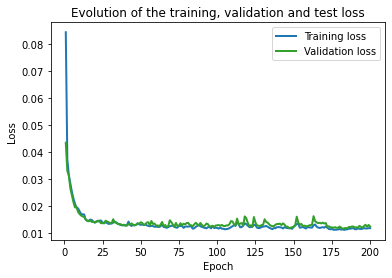

In [101]:
plot_loss(CES_oc_ces.train_loss_history, CES_oc_ces.val_loss_history)

In [97]:
# Pick the best model for each test point
start = time.time()
best_loss_ces, best_model_ces, test_val_loss_history_ces = CES_oc_ces.select_model(inputs)
print('selecting models takes:', time.time()-start)

100%|█████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:03<00:00, 496.47it/s]

selecting models takes: 34.222877740859985


In [102]:
model_list_ces = CES_oc_ces.model_list

# Compute conformity scores of calibration sets for each model
# this initialization will be a one-time effort.
cal_time = time.time()
C_PVals_ces = Conformal_PVals(net_ces, device, val_loader_ces, model_list_ces, random_state = 0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:12<00:00, 16.65it/s]

Initialization done!
Calibration (one time effort) takes:12.02s.


In [103]:
pvals_ces = C_PVals_ces.compute_pvals(inputs, best_model_ces)

NameError: name 'best_model_ces' is not defined

Average p-value for inliers is 0.579221, average p-value for outliers is 0.208869.


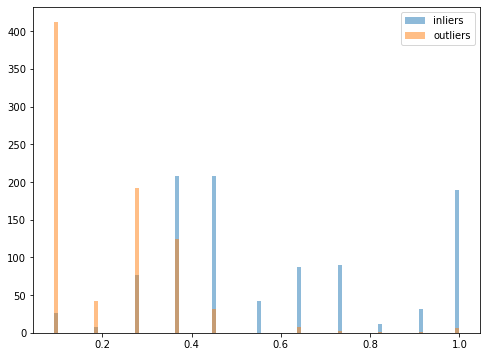

In [117]:
plot_pvals(pvals_ces, labels)

In [118]:
fdp, power = evaluate_bh(pvals_ces, labels, alpha=0.1)
print('Apply BH procedure yields FDP {:3f}, power {:3f}.'.format(fdp,power))

Apply BH procedure yields FDP 0.000000, power 0.000000.


## Apply the naive benchmark
The naive benchmark method uses the same data splitting scheme as CES but it naively use the validation set for both model selection and calibration, hence losing the exchangeability between test points and validation points, potentially causes FDR inflation. The following section explores this naive benchmark and its performance.


In [104]:
# Pick the best model for each test point
start = time.time()
best_loss_naive, best_model_naive, val_loss_history_naive = CES_oc_ces.select_model()
print('best model selected by naive method is stored at:', best_model_naive)
print('selecting models takes:', time.time()-start)

best model selected by naive method is stored at: ./models/oneClass/ces\model182.pth
selecting models takes: 0.0


In [105]:
pvals_naive = C_PVals_ces.compute_pvals(inputs, [best_model_naive]*len(inputs))

100%|█████████████████████████████████████████████████████████████████████████████| 1800/1800 [00:05<00:00, 327.23it/s]

Finished computing p-values for 1800 test points.


Average p-value for inliers is 0.496696, average p-value for outliers is 0.079546.


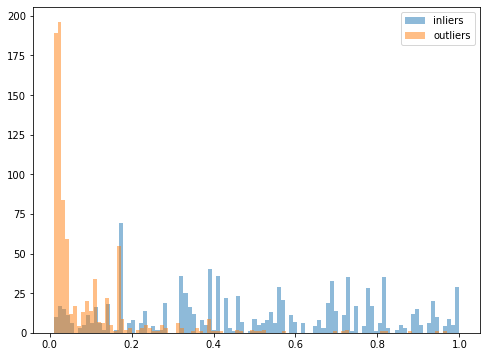

In [106]:
plot_pvals(pvals_naive, labels)

In [107]:
fdp, power = evaluate_bh(pvals_naive, labels, alpha=0.1)
print('Apply BH procedure yields FDP {:3f}, power {:3f}.'.format(fdp,power))

Apply BH procedure yields FDP 0.034444, power 0.684146.


# Experiment 2: CES for multi-class classification

### Load CIFAR10 dataset

In [108]:
num_workers = 2

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Benchmark data-splitting vs CES data-splitting

In [109]:
from torch.utils.data.sampler import SubsetRandomSampler
num_workers = 0

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# MNIST is a simple dataset, hence we only take 300 inlier data to demonstrate
# Benchmark data splitting: equally split the data into 3 sets
n_full = len(train_set)
n_train_bm = 2000
n_val_bm = 1000
n_cal_bm = 1000
n_data = n_train_bm + n_val_bm + n_cal_bm

train_set_bm, val_set_bm, cal_set_bm, _ = th.utils.data.random_split(train_set,\
                                 [n_train_bm, n_val_bm, n_cal_bm, n_full-n_data])

# CES data splitting: calibration set is not needed, merge back to the training set
n_train_ces = 3000
n_val_ces = 1000

train_set_ces, val_set_ces, _ = th.utils.data.random_split(train_set,\
                                 [n_train_ces, n_val_ces, n_full-n_data])


In [110]:
# Create data loader objects
# For benchmarks
batch_size = 64
num_workers = 4

train_loader_bm = th.utils.data.DataLoader(train_set_bm, batch_size=batch_size,
                                          num_workers=num_workers)

val_loader_bm = th.utils.data.DataLoader(val_set_bm, batch_size=100,
                                          num_workers=num_workers)

cal_loader_bm = th.utils.data.DataLoader(cal_set_bm, batch_size=100,
                                          num_workers=num_workers)

# For CES
train_loader_ces = th.utils.data.DataLoader(train_set_ces, batch_size=batch_size,
                                          num_workers=num_workers)

val_loader_ces = th.utils.data.DataLoader(val_set_ces, batch_size=100,
                                          num_workers=num_workers)

In [111]:
# Test loader

seed = 0
np.random.seed(seed)
th.manual_seed(seed)

n_test_samples = 2000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_loader = th.utils.data.DataLoader(test_set, batch_size=n_test_samples, sampler=test_sampler,
                                         num_workers=num_workers)

# get all test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

      bird      plane       deer       bird


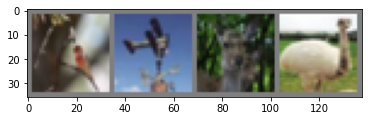

In [112]:
# Plot some sample test data

imshow(torchvision.utils.make_grid(inputs[:4]), norm=True)
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(4)))

### Define CNN

In [113]:
from method import CES_multiClass
from networks import SimpleConvolutionalNetwork
from inference import Conformal_PSet

In [117]:
import torch.optim as optim

# Define the model parameters
lr = 0.0001
n_epoch = 5
n_classes = len(classes)

# Create loss and optimizer
# CES_oneClass object will assume criterion takes three parameters: output, input and target, 
# create wrapper function to modify the criterion.
net_bm = SimpleConvolutionalNetwork()
Loss = th.nn.CrossEntropyLoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, targets)
optimizer_bm = optim.Adam(net_bm.parameters(), lr=lr)

In [115]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

### Train the benchmark model

In [118]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_mc_bm = CES_multiClass(net_bm, device, train_loader_bm, n_classes=n_classes, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_bm, criterion=criterion,optimizer=optimizer_bm)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 5
learning_rate= 0.0001


In [119]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_mc_bm.full_train(save_dir = './models/multiClass/benchmarks', save_every = save_every)

Epoch 1 of 5, 9% 	 train_loss: 2.32 train_acc: 10.94% took: 7.49s
Epoch 1 of 5, 18% 	 train_loss: 2.30 train_acc: 9.38% took: 0.11s
Epoch 1 of 5, 28% 	 train_loss: 2.29 train_acc: 13.02% took: 0.11s
Epoch 1 of 5, 37% 	 train_loss: 2.27 train_acc: 16.67% took: 0.09s
Epoch 1 of 5, 46% 	 train_loss: 2.26 train_acc: 15.10% took: 0.12s
Epoch 1 of 5, 56% 	 train_loss: 2.26 train_acc: 18.75% took: 0.10s
Epoch 1 of 5, 65% 	 train_loss: 2.22 train_acc: 21.35% took: 0.11s
Epoch 1 of 5, 75% 	 train_loss: 2.22 train_acc: 21.88% took: 0.09s
Epoch 1 of 5, 84% 	 train_loss: 2.19 train_acc: 19.27% took: 0.11s
Epoch 1 of 5, 93% 	 train_loss: 2.19 train_acc: 16.15% took: 0.10s
val_loss = 2.18 val_acc = 16.20%
Snapshot saved at epoch 1.
Epoch 2 of 5, 9% 	 train_loss: 2.17 train_acc: 19.27% took: 7.59s
Epoch 2 of 5, 18% 	 train_loss: 2.15 train_acc: 19.27% took: 0.11s
Epoch 2 of 5, 28% 	 train_loss: 2.15 train_acc: 21.35% took: 0.11s
Epoch 2 of 5, 37% 	 train_loss: 2.12 train_acc: 23.96% took: 0.09s
Epoch

In [124]:
%load_ext autoreload
%autoreload 2
from inference import Conformal_PSet

alpha = 0.1
n_classes = len(classes)
model_list_bm = CES_mc_bm.model_list     # Get the saved model list from the CES class

# Compute conformity scores of calibration sets for each model and corresponding calibrated
# confidence level, this might take some time if we have too many saved models but fortunately
# this initialization will be a one-time effort.
cal_time = time.time()
C_PSet_bm = Conformal_PSet(net_bm, device, cal_loader_bm, n_classes, model_list_bm, \
                           alpha, lc=True, random_state=0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Calibrating each model in the list...


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.96s/it]

Initialization done!
Calibration (one time effort) takes:39.81s.


In [125]:
# Pick the best model for each test point
start = time.time()
best_loss_bm, best_model_bm, test_val_loss_history_bm = CES_mc_bm.select_model()
print('selecting models takes:', time.time()-start)

selecting models takes: 0.0


In [129]:
# Get the marginal conformal pvalues 
pset_m_bm= C_PSet_bm.pred_set(inputs, [[best_model_bm]*n_classes]*len(inputs), marginal=True)
# Get the label conditional conformal pvalues 
pset_lc_bm = C_PSet_bm.pred_set(inputs, [[best_model_bm]*n_classes]*len(inputs), marginal=False)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:33<00:00, 21.33it/s]


Finished computing marginal prediction sets for 2000 test points.


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:32<00:00, 21.52it/s]

Finished computing label conditional prediction sets for 2000 test points.


In [130]:
print('Evaluate marginal prediction sets.')
print('='*50)
evaluate_marginal(pset_m_bm, labels.numpy())
print('='*50)
evaluate_conditional(pset_m_bm, labels.numpy())

Evaluate marginal prediction sets.
Marginal coverage:       91.900%
Average size:            6.577
Average size | coverage: 6.580
Conditional coverage for label plane:       88.265%
Average size:            5.949
Average size | coverage: 5.809
Conditional coverage for label car:       94.444%
Average size:            6.576
Average size | coverage: 6.615
Conditional coverage for label bird:       92.821%
Average size:            6.687
Average size | coverage: 6.901
Conditional coverage for label cat:       97.990%
Average size:            6.970
Average size | coverage: 6.985
Conditional coverage for label deer:       85.859%
Average size:            6.773
Average size | coverage: 6.829
Conditional coverage for label dog:       88.108%
Average size:            6.962
Average size | coverage: 6.982
Conditional coverage for label frog:       93.056%
Average size:            6.681
Average size | coverage: 6.617
Conditional coverage for label horse:       94.301%
Average size:            7.05

In [131]:
print('Evaluate label conditional prediction sets.')
print('='*50)
evaluate_marginal(pset_lc_bm, labels.numpy())
print('='*50)
evaluate_conditional(pset_lc_bm, labels.numpy())

Evaluate label conditional prediction sets.
Marginal coverage:       92.950%
Average size:            6.721
Average size | coverage: 6.748
Conditional coverage for label plane:       91.327%
Average size:            5.995
Average size | coverage: 5.939
Conditional coverage for label car:       92.424%
Average size:            6.758
Average size | coverage: 6.831
Conditional coverage for label bird:       89.744%
Average size:            6.826
Average size | coverage: 7.120
Conditional coverage for label cat:       97.487%
Average size:            7.060
Average size | coverage: 7.082
Conditional coverage for label deer:       91.414%
Average size:            6.874
Average size | coverage: 6.934
Conditional coverage for label dog:       95.676%
Average size:            7.086
Average size | coverage: 7.119
Conditional coverage for label frog:       96.759%
Average size:            6.769
Average size | coverage: 6.722
Conditional coverage for label horse:       90.155%
Average size:       

### Train the CES model

In [51]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

net_ces = SimpleConvolutionalNetwork()
Loss = th.nn.CrossEntropyLoss()
def criterion(outputs, inputs, targets):
    return Loss(outputs, targets)
optimizer_ces = optim.Adam(net_ces.parameters(), lr=lr)

# Initialize the CES class with model parameters
CES_mc_ces = CES_multiClass(net_ces, device, train_loader_ces, n_classes=n_classes, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader_ces, criterion=criterion,optimizer=optimizer_ces)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 10
learning_rate= 0.001


In [52]:
seed = 0
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

In [53]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_mc_ces.full_train(save_dir = './models/multiClass/ces', save_every = save_every)

Epoch 1 of 10, 8% 	 train_loss: 2.26 train_acc: 17.97% took: 5.57s
Epoch 1 of 10, 17% 	 train_loss: 2.22 train_acc: 16.41% took: 0.07s
Epoch 1 of 10, 25% 	 train_loss: 2.11 train_acc: 25.39% took: 0.06s
Epoch 1 of 10, 34% 	 train_loss: 2.05 train_acc: 28.91% took: 0.07s
Epoch 1 of 10, 42% 	 train_loss: 2.05 train_acc: 23.05% took: 0.06s
Epoch 1 of 10, 51% 	 train_loss: 2.06 train_acc: 25.78% took: 0.08s
Epoch 1 of 10, 59% 	 train_loss: 2.01 train_acc: 27.73% took: 0.07s
Epoch 1 of 10, 68% 	 train_loss: 1.96 train_acc: 28.12% took: 0.06s
Epoch 1 of 10, 76% 	 train_loss: 1.93 train_acc: 28.12% took: 0.06s
Epoch 1 of 10, 85% 	 train_loss: 1.79 train_acc: 39.45% took: 0.08s
Epoch 1 of 10, 93% 	 train_loss: 1.90 train_acc: 31.64% took: 0.06s
val_loss = 1.83 val_acc = 34.20%
Snapshot saved at epoch 1.
Epoch 2 of 10, 8% 	 train_loss: 1.77 train_acc: 36.72% took: 5.86s
Epoch 2 of 10, 17% 	 train_loss: 1.77 train_acc: 40.23% took: 0.07s
Epoch 2 of 10, 25% 	 train_loss: 1.79 train_acc: 35.94% to

In [54]:
alpha = 0.1
model_list_ces = CES_mc_ces.model_list     # Get the saved model list from the CES class

# Compute conformity scores of calibration sets for each model and corresponding calibrated
# confidence level, this might take some time if we have too many saved models but fortunately
# this initialization will be a one-time effort.
cal_time = time.time()
C_PSet_ces = Conformal_PSet(net_ces, device, val_loader_ces, n_classes, model_list_ces, \
                           alpha,random_state = 0)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

Calibrating each model in the list...


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.11s/it]

Initialization done!
Calibration (one time effort) takes:71.08s.


In [55]:
# Pick the best model for each test point
start = time.time()
best_loss_ces, best_model_ces, test_val_loss_history_ces = CES_mc_ces.select_model(inputs)
print('selecting models takes:', time.time()-start)

Loading model 0 of 10...


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 257.08it/s]

Loading model 1 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 183.39it/s]

Loading model 2 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 187.50it/s]

Loading model 3 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 188.73it/s]

Loading model 4 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 181.11it/s]

Loading model 5 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 185.71it/s]

Loading model 6 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 188.64it/s]

Loading model 7 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 189.13it/s]

Loading model 8 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 187.93it/s]

Loading model 9 of 10...



100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 188.44it/s]

selecting models takes: 104.24921941757202


In [56]:
# Get the marginal conformal pvalues 
pset_m_ces= C_PSet_ces.pred_set(inputs, best_model_ces, marginal=True)
# Get the label conditional conformal pvalues 
pset_lc_ces = C_PSet_ces.pred_set(inputs, best_model_ces, marginal=False)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 50.22it/s]


Finished computing marginal prediction sets for 2000 test points.


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:47<00:00, 41.73it/s]

Finished computing label conditional prediction sets for 2000 test points.


In [57]:
print('Evaluate marginal prediction sets.')
print('='*50)
evaluate_marginal(pset_m_ces, labels.numpy())
print('='*50)
evaluate_conditional(pset_m_ces, labels.numpy())

Evaluate marginal prediction sets.
Marginal coverage:       90.750%
Average size:            4.452
Average size | coverage: 4.482
Conditional coverage for label plane:       85.714%
Average size:            3.730
Average size | coverage: 3.607
Conditional coverage for label car:       95.960%
Average size:            3.566
Average size | coverage: 3.537
Conditional coverage for label bird:       90.769%
Average size:            4.626
Average size | coverage: 4.768
Conditional coverage for label cat:       83.417%
Average size:            5.503
Average size | coverage: 5.663
Conditional coverage for label deer:       91.919%
Average size:            4.742
Average size | coverage: 4.775
Conditional coverage for label dog:       94.595%
Average size:            4.924
Average size | coverage: 4.994
Conditional coverage for label frog:       94.907%
Average size:            5.157
Average size | coverage: 5.210
Conditional coverage for label horse:       91.192%
Average size:            4.95

In [58]:
print('Evaluate label conditional prediction sets.')
print('='*50)
evaluate_marginal(pset_lc_ces, labels.numpy())
print('='*50)
evaluate_conditional(pset_lc_ces, labels.numpy())

Evaluate label conditional prediction sets.
Marginal coverage:       90.100%
Average size:            4.410
Average size | coverage: 4.452
Conditional coverage for label plane:       88.776%
Average size:            3.612
Average size | coverage: 3.511
Conditional coverage for label car:       94.444%
Average size:            3.722
Average size | coverage: 3.717
Conditional coverage for label bird:       91.282%
Average size:            4.533
Average size | coverage: 4.702
Conditional coverage for label cat:       88.442%
Average size:            5.397
Average size | coverage: 5.528
Conditional coverage for label deer:       83.333%
Average size:            4.763
Average size | coverage: 4.861
Conditional coverage for label dog:       88.649%
Average size:            4.795
Average size | coverage: 4.860
Conditional coverage for label frog:       93.056%
Average size:            5.083
Average size | coverage: 5.154
Conditional coverage for label horse:       91.192%
Average size:       